Things to add:

1. Server for the files to be hosted and accessed easily
2. Download mechanism
3. ~~Plotting mechanism~~
4. ~~Pandas dataframe mechanism (put chronologies or other outputs into a dataframe)~~
5. ~~Delta age calc~~
6. ~~multi-core access~~
7. ~~Make the output only the asked for inputs~~
8. Pull tiepoints and add to program


Qs: 
What is the _model ones?

In [74]:
# first initial work on the python package

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025')

current_dir = os.getcwd()

In [76]:
def bicc_list_cores():
    folders = [
    f for f in os.listdir(current_dir)
    if os.path.isdir(os.path.join(current_dir, f)) and "-" not in f]
    print(f'The current ice cores in BICC are as follows: {folders}')

def bicc_list_links():
    links = sorted([
    f for f in os.listdir(current_dir)
    if os.path.isdir(os.path.join(current_dir, f)) and "-" in f
    ])
    print(f'The current ice core links in BICC are as follows: {links}')

#types list: 

ice_age
air_age
delta_age
deporate
thinning
LID
delta_depth

In [77]:
def bicc(cores, types=['ice_age'], plot=False):

    #require correct input type
    if not isinstance(types, (list, str)):
        print('Please supply types as either a list (singular or multiple) or a string (singular)')
        return
    
    if not isinstance(cores, (list, str)):
        print('Please supply core(s) as either a list (singular or multiple) or a string (singular)')
        return
    
    #convert string to list
    if isinstance(types, str):
        types = [types]

    #convert string to list
    if isinstance(cores, str):
        cores = [cores]


    index_vals = {
        'ice_age': 1,
        'air_age': 3,
        'delta_age': 5,
        'deporate': 7,
        'thinning': 9,
        'lid': 11,
        'delta_depth': 13
    }

    #make sure the input type exists
    for type in types:
        if type.lower() not in index_vals:
            print(f'{type} is not a valid type. Please select from {list(index_vals.keys())}.')
            return

    #get the existing cores to make sure the input is valid
    folders = [
    f for f in os.listdir(current_dir)
    if os.path.isdir(os.path.join(current_dir, f)) and "-" not in f]

    for core in cores:
        if core.upper() not in folders:
            print(f'{core} is not a valid ice core in BICC. Please check your spelling and try again.')
            bicc_list_cores()
            return
        
    core_data = {}

    #load in full dataset
    for core in cores:
        bicc_output = pd.read_csv(os.path.join(current_dir, core, 'output.txt'), sep='\t', usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], names=['depth_m', 'ice_age_yr', 'sigma_ice_age', 
                                                                                                                                            'air_age_yr', 'sigma_air_age', 'sigma_delta_age',
                                                                                                                                            'deporate_m_yr', 'sigma_deporate', 'thinning', 
                                                                                                                                            'sigma_thinning', 'LID_m', 'sigma_LID', 'delta_depth_m', 
                                                                                                                                            'sigma_delta_depth'], skiprows=1)
        core_data[core] = bicc_output
        
        # Compute delta_age
        core_data[core]['delta_age'] = core_data[core]['ice_age_yr'] - core_data[core]['air_age_yr']
        # Move it right after 'sigma_air_age' and delete original column
        col_index = core_data[core].columns.get_loc('sigma_air_age') + 1
        core_data[core].insert(col_index, 'delta_age', core_data[core].pop('delta_age'))


    # create the plot
    if plot == True:
        if len(types) > 1:
            print('Please select only one type to plot at a time.')
            return

        for core in cores:
            df = core_data[core]  # dataframe for this core
            col = index_vals[types[0]]

            plt.plot(df.iloc[:, col], df.iloc[:, 0], label=f"{core.upper()}")

            plt.fill_betweenx(
                df.iloc[:, 0],
                df.iloc[:, col] - df.iloc[:, col + 1],
                df.iloc[:, col] + df.iloc[:, col + 1],
                alpha=0.4
            )

        plt.xlabel(df.columns[col])
        plt.ylabel("Depth (m)")
        plt.title(f"(BICC) {types[0].upper()} Output")
        ax = plt.gca()
        ax.invert_yaxis()
        plt.legend()
        plt.show()

    #create the dataset for the depth and types (ice age, air age, etc)
    return_bicc = {}

    for core in cores:
        return_bicc[core] = core_data[core].iloc[:, [0] + [index_vals[t] for t in types] + [index_vals[t]+1 for t in types]]

    return return_bicc


In [ ]:
def bicc_links(links, plot=False):

    #require correct input type
    if not isinstance(links, (str)):
        print('Please supply link as a string')
        return

    #get the existing cores to make sure the input is valid
    links_list = sorted([f for f in os.listdir(current_dir) if os.path.isdir(os.path.join(current_dir, f)) and "-" in f])

    if links.upper() not in links_list:
        print(f'{links} is not a valid ice core link in BICC. Please check your spelling and try again.')
        bicc_list_links()
        return

    #names of each core
    core1 = links.split('-')[0]
    core2 = links.split('-')[1]

    #load in full dataset
    ice_ice = pd.read_csv(os.path.join(current_dir, links, 'iceice_synchro_horizons.txt'), sep='\t', comment='#', skiprows=1, usecols=[0,1,2], names=[f'{core1}_depth_m', f'{core2}_depth_m', 'age_uncertainty']) 
    air_ice = pd.read_csv(os.path.join(current_dir, links, 'airice_synchro_horizons.txt'), sep='\t', comment='#', skiprows=1, usecols=[0,1,2], names=[f'{core1}_depth_m', f'{core2}_depth_m', 'age_uncertainty']) 
    ice_air = pd.read_csv(os.path.join(current_dir, links, 'iceair_synchro_horizons.txt'), sep='\t', comment='#', skiprows=1, usecols=[0,1,2], names=[f'{core1}_depth_m', f'{core2}_depth_m', 'age_uncertainty']) 
    air_air = pd.read_csv(os.path.join(current_dir, links, 'airair_synchro_horizons.txt'), sep='\t', comment='#', skiprows=1, usecols=[0,1,2], names=[f'{core1}_depth_m', f'{core2}_depth_m', 'age_uncertainty']) 


    # create the plot
    if plot == True:
        if len(types) > 1:
            print('Please select only one type to plot at a time.')
            return

        for core in cores:
            df = core_data[core]  # dataframe for this core
            col = index_vals[types[0]]

            plt.plot(df.iloc[:, col], df.iloc[:, 0], label=f"{core.upper()}")

            plt.fill_betweenx(
                df.iloc[:, 0],
                df.iloc[:, col] - df.iloc[:, col + 1],
                df.iloc[:, col] + df.iloc[:, col + 1],
                alpha=0.4
            )

        plt.xlabel(df.columns[col])
        plt.ylabel("Depth (m)")
        plt.title(f"(BICC) {types[0].upper()} Output")
        ax = plt.gca()
        ax.invert_yaxis()
        plt.legend()
        plt.show()

    #create the dataset for the depth and types (ice age, air age, etc)
    return_bicc = {}

    for core in cores:
        return_bicc[core] = core_data[core].iloc[:, [0] + [index_vals[t] for t in types] + [index_vals[t]+1 for t in types]]

    return return_bicc


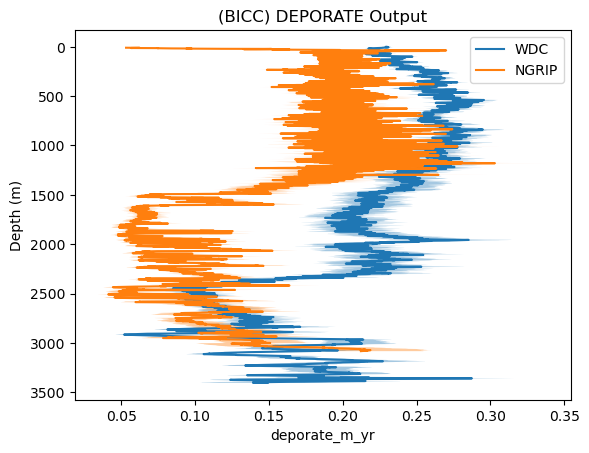

In [81]:
temp = bicc(['wdc', 'ngrip'], types='deporate', plot=True)

In [82]:
temp

{'wdc':       depth_m  deporate_m_yr  sigma_deporate
 0        0.36       0.229615        0.003091
 1        1.36       0.229615        0.003091
 2        2.36       0.229615        0.003091
 3        3.36       0.229040        0.003033
 4        4.36       0.229131        0.002979
 ...       ...            ...             ...
 3400  3400.36       0.139279        0.035888
 3401  3401.36       0.147621        0.037497
 3402  3402.36       0.149516        0.037484
 3403  3403.36       0.139556        0.034977
 3404  3404.36       0.139556        0.034977
 
 [3405 rows x 3 columns],
 'ngrip':       depth_m  deporate_m_yr  sigma_deporate
 0         9.9       0.053222        0.000451
 1        10.9       0.062433        0.000473
 2        11.9       0.059051        0.000392
 3        12.9       0.056525        0.000319
 4        13.9       0.074949        0.000360
 ...       ...            ...             ...
 3070   3079.9       0.214399        0.039316
 3071   3080.9       0.213652       